In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

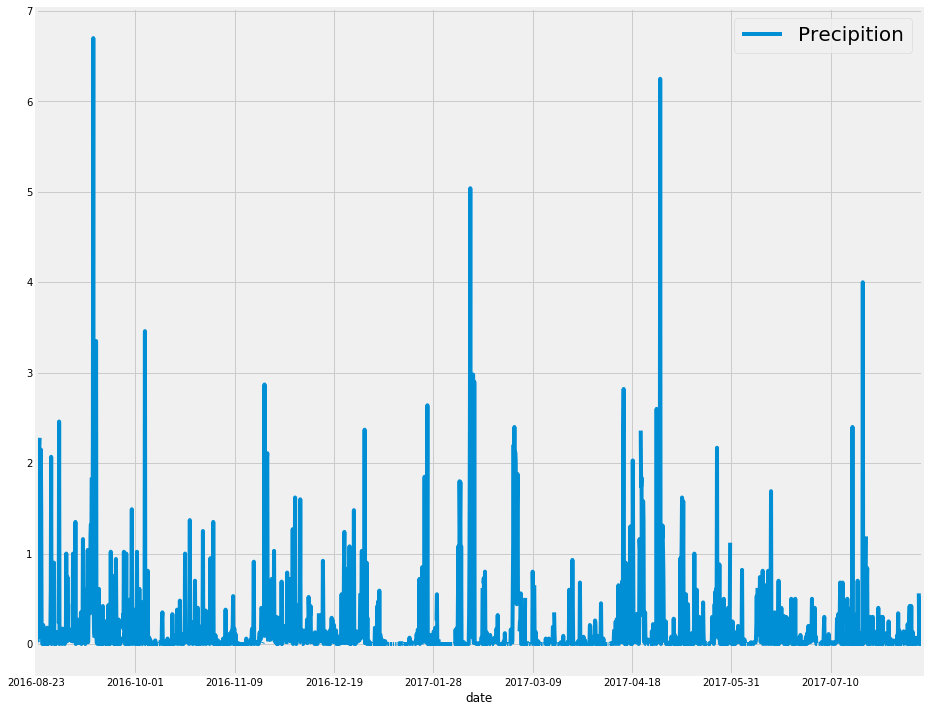

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_entry = session.query(Measurement.date, func.max(Measurement.id)).all()
last_date = dt.datetime.strptime(last_entry[0][0], "%Y-%m-%d")
date_1_year_ago = (last_date - dt.timedelta(days = 365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= date_1_year_ago).order_by(Measurement.date).statement
df_prcp = pd.read_sql_query(prcp, con = engine).set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data

df_prcp.plot(figsize = (13,10))
plt.legend(['Precipition'], loc = "best", fontsize = 20)
plt.tick_params(axis = "x", which = "both",top = False, bottom = False)
plt.tight_layout()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Measurement.station).group_by('station').count()
num_of_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.id)).group_by('station').order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp

[(54.0, 85.0, 71.66378066378067)]

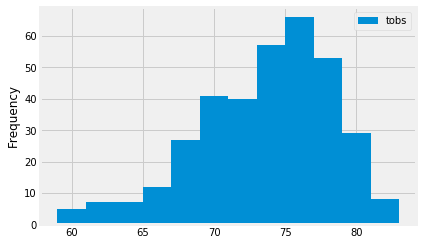

In [15]:
# Choose the station with the highest number of temperature observations.
max_tempnum_station = stations[0][0] # get the station with highest num of temp observations by the stations list above

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_month_temp = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == max_tempnum_station, Measurement.date >= date_1_year_ago).all()
# Create the date frame for hist plot
last_12_month_temp_df = pd.DataFrame(last_12_month_temp)

# Histogram plotting
last_12_month_temp_df.plot.hist(bins = 12)


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = date_1_year_ago
end_date = last_date
print(calc_temps(start_date,end_date))

[(58.0, 74.59058295964125, 87.0)]


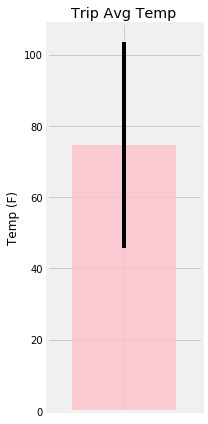

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (3,6))
diff = calc_temps(start_date,end_date)[0][2]-calc_temps(start_date,end_date)[0][0]
plt.bar(np.arange(1),calc_temps(start_date,end_date)[0][1], yerr = diff, width = 0.2, alpha = 0.8, color = "pink" )
plt.xlim(-0.15,0.15)
plt.title("Trip Avg Temp")
plt.xticks(np.arange(1), "")
plt.ylabel("Temp (F)")
plt.tight_layout()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

last_12_month = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation, func.sum(Measurement.prcp)).group_by(Measurement.station).filter(Measurement.station == Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
print(last_12_month)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1068.0899999999956), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 588.6399999999976), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 382.61999999999847), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 295.67999999999944), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 234.49000000000026), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 131.62000000000063), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 92.68000000000006), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 70.87000000000005), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 43.44000000000002)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = date_1_year_ago
end_date = last_date
# Use the start and end date to create a range of dates
results = session.query(Measurement.date).filter(Measurement.date >= start_date, Measurement.date <= end_date).all()
dates = []
for date in results:
    # Stip off the year and save a list of %m-%d strings
    dates.append(date[0][5:])

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    normals.append(daily_normals(date)[0])


In [22]:
# Preview the normals
normals[:5]

[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"], index = dates)
normals_df.index.name = "date"
normals_df.head()

,tmin,tavg,tmax
date,,,
08-23,67.0,76.692308,87.0
08-24,70.0,75.961538,84.0
08-25,69.0,76.960784,82.0
08-26,71.0,76.568627,84.0
08-27,68.0,76.283019,84.0


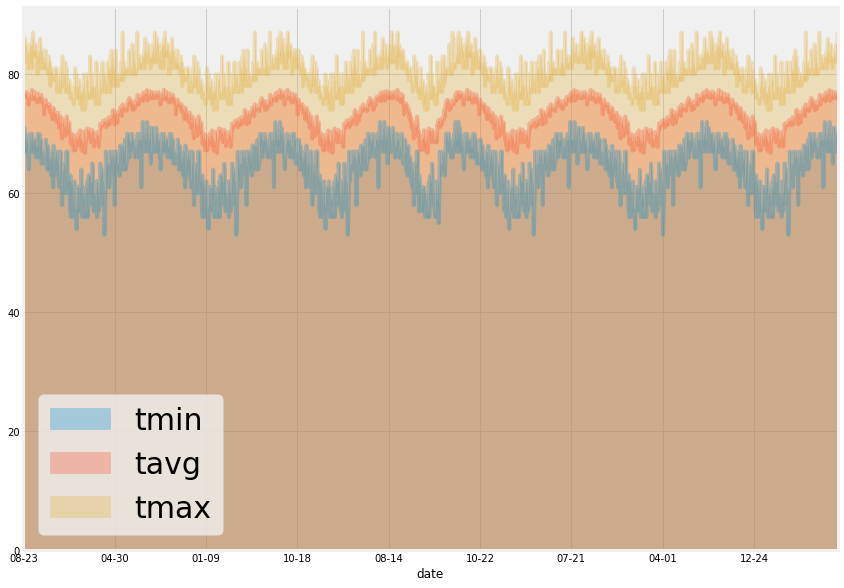

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind = "area",stacked = False, figsize = (13,10), alpha = 0.3)
plt.legend(fontsize = 30)

In [25]:

#### Run Flask in Jupyter

import app
if __name__ == "__main__":
    
    app.app.run(debug=False)

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [03/Dec/2019 16:08:43] "GET / HTTP/1.1" 200 -
